<a href="https://colab.research.google.com/github/Guljeren/Ml_lab/blob/main/lab_4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Импорт библиотек
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks


kaggle_config = {"username": "your_username", "key": "your_api_key"}
os.makedirs('/root/.config/kaggle', exist_ok=True)
with open('/root/.config/kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_config, f)
os.chmod('/root/.config/kaggle/kaggle.json', 0o600)

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files('uciml/german-credit', path='./data', unzip=True)

csv_files = [f for f in os.listdir('./data') if f.endswith('.csv')]
csv_path = os.path.join('./data', csv_files[0])
df = pd.read_csv(csv_path)

# Проверяем данные
print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
print(df.head())
print("\nНазвания колонок:")
print(df.columns.tolist())

Dataset URL: https://www.kaggle.com/datasets/uciml/german-credit
Размер датасета: (1000, 10)

Первые 5 строк:
   Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  
0           1169         6             radio/TV  
1           5951        48             radio/TV  
2           2096        12            education  
3           7882        42  furniture/equipment  
4           4870        24                  car  

Названия колонок:
['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration',

Распределение классов в обучающей выборке:
credit_class
1    401
0    241
2    158
Name: count, dtype: int64

Распределение классов в тестовой выборке:
credit_class
1    105
0     65
2     30
Name: count, dtype: int64


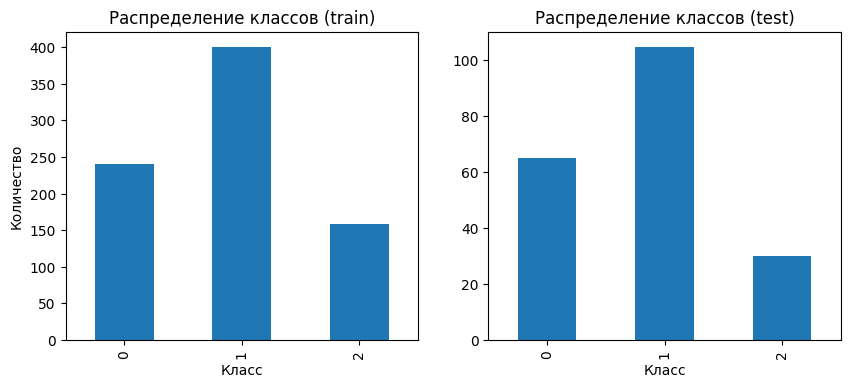

In [2]:
# Создаем целевую переменную для классификации
def amount_to_class(amount):
    if amount <= 1500:
        return 0  # Низкий
    elif amount <= 5000:
        return 1  # Средний
    else:
        return 2  # Высокий

df['credit_class'] = df['Credit amount'].apply(amount_to_class)

# Удаляем исходный числовой признак
X = df.drop(['Credit amount', 'credit_class'], axis=1)
y = df['credit_class']

# Преобразуем категориальные признаки
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X[col] = pd.factorize(X[col])[0]

# Разделяем на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Распределение классов в обучающей выборке:")
print(y_train.value_counts())
print("\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts())

# Визуализация распределения классов
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
y_train.value_counts().sort_index().plot(kind='bar')
plt.title('Распределение классов (train)')
plt.xlabel('Класс')
plt.ylabel('Количество')

plt.subplot(1, 2, 2)
y_test.value_counts().sort_index().plot(kind='bar')
plt.title('Распределение классов (test)')
plt.xlabel('Класс')
plt.show()

In [3]:
# 1) Обучаем модель на исходных данных
dt_base = DecisionTreeClassifier(random_state=42)
dt_base.fit(X_train, y_train)
y_pred_base = dt_base.predict(X_test)
accuracy_base = accuracy_score(y_test, y_pred_base)

print("БАЗОВАЯ МОДЕЛЬ (исходные данные):")
print(f"Accuracy: {accuracy_base:.4f}")
print(f"Распределение классов в train: {dict(y_train.value_counts())}")
print(f"Распределение классов в test: {dict(y_test.value_counts())}")

БАЗОВАЯ МОДЕЛЬ (исходные данные):
Accuracy: 0.5500
Распределение классов в train: {1: np.int64(401), 0: np.int64(241), 2: np.int64(158)}
Распределение классов в test: {1: np.int64(105), 0: np.int64(65), 2: np.int64(30)}


In [4]:
# Проверяем балансировку
class_counts = y_train.value_counts()
print("Текущее распределение классов:")
print(class_counts)
print(f"\nСамый большой класс: {class_counts.idxmax()} с {class_counts.max()} образцами")

# Создаем дисбаланс: оставляем только 10% от самого большого класса в меньшем классе
majority_class = class_counts.idxmax()
minority_class = class_counts.idxmin()

# Находим индексы меньшего класса
minority_indices = y_train[y_train == minority_class].index

# Оставляем только 10% от количества в самом большом классе
n_to_keep = int(class_counts.max() * 0.1)
if n_to_keep < len(minority_indices):
    # Случайно выбираем какие образцы оставить
    np.random.seed(42)
    keep_indices = np.random.choice(minority_indices, size=n_to_keep, replace=False)

    # Создаем новые выборки с дисбалансом
    balanced_indices = list(y_train[y_train != minority_class].index) + list(keep_indices)
    X_train_imbalanced = X_train.loc[balanced_indices]
    y_train_imbalanced = y_train.loc[balanced_indices]
else:
    X_train_imbalanced = X_train.copy()
    y_train_imbalanced = y_train.copy()

print(f"\nСОЗДАНИЕ ДИСБАЛАНСА:")
print(f"Оставляем {n_to_keep} образцов из класса {minority_class} (10% от {class_counts.max()})")
print(f"Новое распределение классов: {dict(y_train_imbalanced.value_counts())}")

# 2) Обучаем модель на данных с дисбалансом
dt_imbalanced = DecisionTreeClassifier(random_state=42)
dt_imbalanced.fit(X_train_imbalanced, y_train_imbalanced)
y_pred_imbalanced = dt_imbalanced.predict(X_test)
accuracy_imbalanced = accuracy_score(y_test, y_pred_imbalanced)

print(f"\nМОДЕЛЬ С ДИСБАЛАНСОМ:")
print(f"Accuracy: {accuracy_imbalanced:.4f}")

Текущее распределение классов:
credit_class
1    401
0    241
2    158
Name: count, dtype: int64

Самый большой класс: 1 с 401 образцами

СОЗДАНИЕ ДИСБАЛАНСА:
Оставляем 40 образцов из класса 2 (10% от 401)
Новое распределение классов: {1: np.int64(401), 0: np.int64(241), 2: np.int64(40)}

МОДЕЛЬ С ДИСБАЛАНСОМ:
Accuracy: 0.5250


In [5]:
# Создаем словарь для хранения результатов
results = {
    'Базовая': accuracy_base,
    'С дисбалансом': accuracy_imbalanced
}

# 3а) Метод копирования экземпляров (oversampling)
from imblearn.over_sampling import RandomOverSampler

print("\n--- МЕТОДЫ БАЛАНСИРОВКИ ---")

# Копирование
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train_imbalanced, y_train_imbalanced)

print(f"\n1. КОПИРОВАНИЕ ЭКЗЕМПЛЯРОВ (RandomOverSampler):")
print(f"   Распределение после балансировки: {dict(pd.Series(y_train_ros).value_counts())}")

dt_ros = DecisionTreeClassifier(random_state=42)
dt_ros.fit(X_train_ros, y_train_ros)
y_pred_ros = dt_ros.predict(X_test)
accuracy_ros = accuracy_score(y_test, y_pred_ros)
results['Копирование'] = accuracy_ros
print(f"   Accuracy: {accuracy_ros:.4f}")

# 3б) SMOTE
try:
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_imbalanced, y_train_imbalanced)

    print(f"\n2. SMOTE:")
    print(f"   Распределение после балансировки: {dict(pd.Series(y_train_smote).value_counts())}")

    dt_smote = DecisionTreeClassifier(random_state=42)
    dt_smote.fit(X_train_smote, y_train_smote)
    y_pred_smote = dt_smote.predict(X_test)
    accuracy_smote = accuracy_score(y_test, y_pred_smote)
    results['SMOTE'] = accuracy_smote
    print(f"   Accuracy: {accuracy_smote:.4f}")
except Exception as e:
    print(f"\n2. SMOTE: Ошибка - {e}")
    results['SMOTE'] = None

# 3в) ADASYN
try:
    adasyn = ADASYN(random_state=42)
    X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_imbalanced, y_train_imbalanced)

    print(f"\n3. ADASYN:")
    print(f"   Распределение после балансировки: {dict(pd.Series(y_train_adasyn).value_counts())}")

    dt_adasyn = DecisionTreeClassifier(random_state=42)
    dt_adasyn.fit(X_train_adasyn, y_train_adasyn)
    y_pred_adasyn = dt_adasyn.predict(X_test)
    accuracy_adasyn = accuracy_score(y_test, y_pred_adasyn)
    results['ADASYN'] = accuracy_adasyn
    print(f"   Accuracy: {accuracy_adasyn:.4f}")
except Exception as e:
    print(f"\n3. ADASYN: Ошибка - {e}")
    results['ADASYN'] = None

# 3г) TomekLinks (undersampling)
try:
    tl = TomekLinks()
    X_train_tl, y_train_tl = tl.fit_resample(X_train_imbalanced, y_train_imbalanced)

    print(f"\n4. TomekLinks:")
    print(f"   Распределение после балансировки: {dict(pd.Series(y_train_tl).value_counts())}")
    print(f"   Удалено {len(X_train_imbalanced) - len(X_train_tl)} образцов")

    dt_tl = DecisionTreeClassifier(random_state=42)
    dt_tl.fit(X_train_tl, y_train_tl)
    y_pred_tl = dt_tl.predict(X_test)
    accuracy_tl = accuracy_score(y_test, y_pred_tl)
    results['TomekLinks'] = accuracy_tl
    print(f"   Accuracy: {accuracy_tl:.4f}")
except Exception as e:
    print(f"\n4. TomekLinks: Ошибка - {e}")
    results['TomekLinks'] = None


--- МЕТОДЫ БАЛАНСИРОВКИ ---

1. КОПИРОВАНИЕ ЭКЗЕМПЛЯРОВ (RandomOverSampler):
   Распределение после балансировки: {1: np.int64(401), 0: np.int64(401), 2: np.int64(401)}
   Accuracy: 0.5500

2. SMOTE:
   Распределение после балансировки: {1: np.int64(401), 0: np.int64(401), 2: np.int64(401)}
   Accuracy: 0.4750

3. ADASYN:
   Распределение после балансировки: {1: np.int64(401), 2: np.int64(400), 0: np.int64(399)}
   Accuracy: 0.5350

4. TomekLinks:
   Распределение после балансировки: {1: np.int64(309), 0: np.int64(157), 2: np.int64(40)}
   Удалено 176 образцов
   Accuracy: 0.5500


Базовая              : 0.5500
С дисбалансом        : 0.5250
Копирование          : 0.5500
SMOTE                : 0.4750
ADASYN               : 0.5350
TomekLinks           : 0.5500


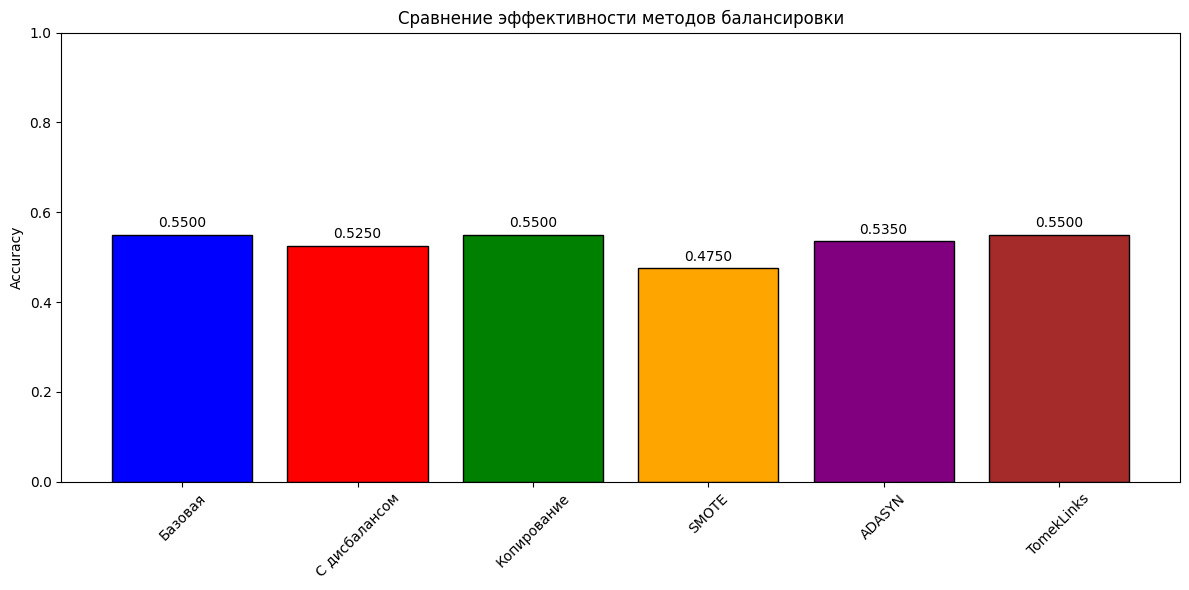

 Лучший результат: Базовая с accuracy = 0.5500
 Худший результат: SMOTE с accuracy = 0.4750


In [11]:
# Визуализация результатов
# Удаляем None значения
valid_results = {k: v for k, v in results.items() if v is not None}

for method, acc in valid_results.items():
    print(f"{method:20} : {acc:.4f}")

# График сравнения
plt.figure(figsize=(12, 6))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
bars = plt.bar(range(len(valid_results)), list(valid_results.values()),
               color=colors[:len(valid_results)], edgecolor='black')

plt.xticks(range(len(valid_results)), list(valid_results.keys()), rotation=45)
plt.ylabel('Accuracy')
plt.title('Сравнение эффективности методов балансировки')
plt.ylim(0, 1)

# Добавляем значения на столбцы
for bar, acc in zip(bars, valid_results.values()):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Анализ результатов
best_method = max(valid_results, key=valid_results.get)
worst_method = min(valid_results, key=valid_results.get)

print(f" Лучший результат: {best_method} с accuracy = {valid_results[best_method]:.4f}")
print(f" Худший результат: {worst_method} с accuracy = {valid_results[worst_method]:.4f}")